In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import os
# Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv('/content/drive/My Drive/RideSharing/data.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


# **Feature Engineering**

> Time features engineering:

In [11]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['datetime'].apply(lambda x: x.year)
df['month'] = df['datetime'].apply(lambda x: x.month)
df['day'] = df['datetime'].apply(lambda x: x.dayofweek)
# df['day'] = df['day'].map({0: 2, 1: 3, 2: 4, 3: 5, 4: 6, 5: 7, 6: 1}) # Sunday=1, Saturday=7
df['hour'] = df['datetime'].apply(lambda x: x.hour)

In [12]:
for col in ['season', 'holiday', 'workingday', 'weather']:
    df[col] = df[col].astype("category")

In [13]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [14]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,1,5,4


In [15]:
daily_cols = ['date', 'year', 'month', 'day', 'season', 'holiday', 'workingday']

for col in ['temp', 'atemp', 'humidity', 'windspeed']:
    agg_col_name = f'avg_{col}'
    df[agg_col_name] = df.groupby('date')[col].transform('mean')
    daily_cols.append(agg_col_name)
    
for col in ['casual', 'registered', 'count']:
    agg_col_name = f'tot_{col}'
    df[agg_col_name] = df.groupby('date')[col].transform('sum')
    daily_cols.append(agg_col_name)

In [16]:
daily_df = df.loc[:, daily_cols].drop_duplicates()

In [17]:
daily_df = daily_df.set_index('date')

In [18]:
daily_df.head()

,year,month,day,season,holiday,workingday,avg_temp,avg_atemp,avg_humidity,avg_windspeed,tot_casual,tot_registered,tot_count
date,,,,,,,,,,,,,
2011-01-01,2011,1,5,1,0,0,14.110833,18.181250,80.583333,10.749871,331,654,985
2011-01-02,2011,1,6,1,0,0,14.902609,17.686957,69.608696,16.652122,131,670,801
2011-01-03,2011,1,0,1,0,1,8.050909,9.470227,43.727273,16.636709,120,1229,1349
2011-01-04,2011,1,1,1,0,1,8.200000,10.606087,59.043478,10.739809,108,1454,1562
2011-01-05,2011,1,2,1,0,1,9.305217,11.463478,43.695652,12.522300,82,1518,1600


# **Data Exploration**

In [19]:
annualy_demands = df.groupby('year')[['casual', 'registered', 'count']].sum()
annualy_demands

,casual,registered,count
year,,,
2011,155817,626162,781979
2012,236318,1067179,1303497


<Figure size 864x864 with 0 Axes>

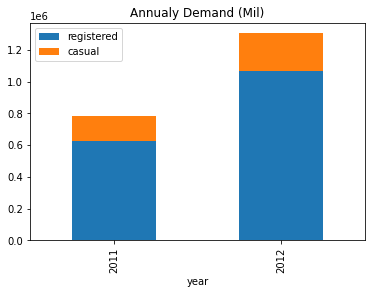

In [20]:
plt.figure(figsize=(12, 12))
annualy_demands[['registered', 'casual']].plot(kind='bar', stacked=True)
plt.title('Annualy Demand (Mil)')
plt.show()

* 80% of the clients in 2011 was registred
* 82% of the clients in 2012 was registred
* 67% YOY growth


Text(0, 0.5, 'Demand (units)')

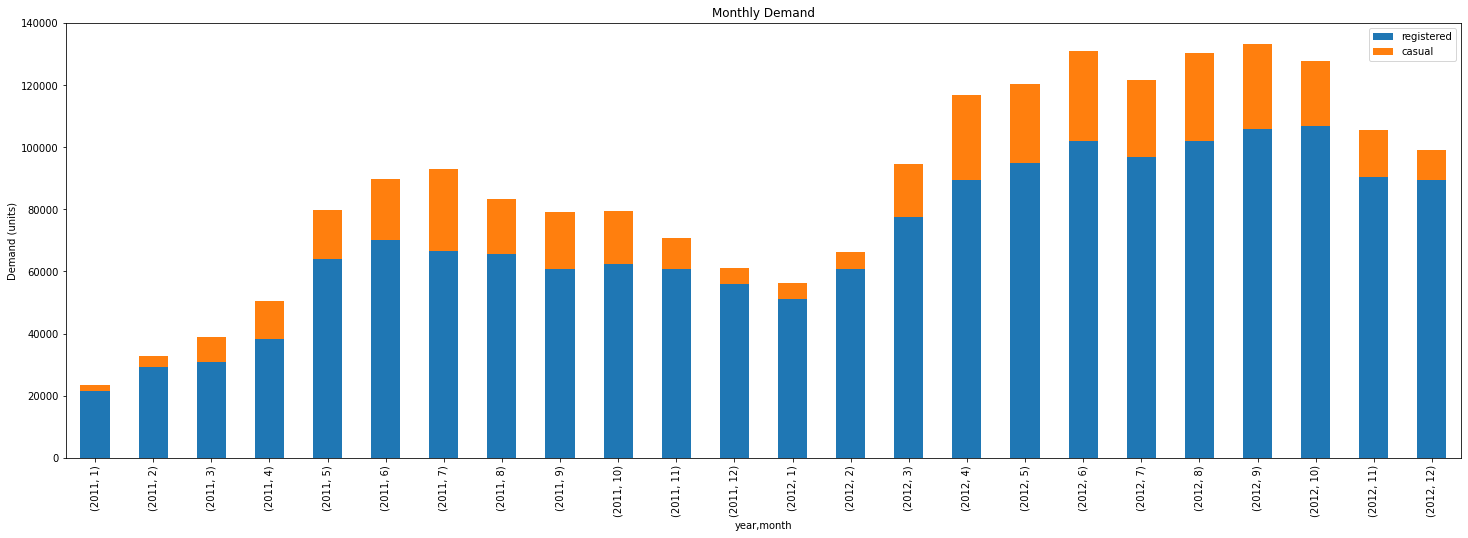

In [21]:
monthly_demands = df.groupby(['year', 'month'])[['casual', 'registered', 'count']].sum()
monthly_demands[['registered', 'casual']].plot(kind='bar', stacked=True, figsize=(25,8))
plt.title('Monthly Demand')
plt.ylabel('Demand (units)')

[Text(0, 0.5, 'Daily Demand'),
 Text(0.5, 1.0, 'Box Plot for Daily Demand by Day Of Week')]

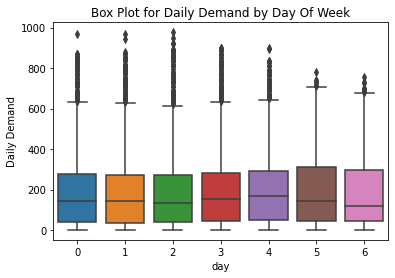

In [22]:
sns.boxplot(data=df,y="count",x="day",orient="v").set(ylabel='Daily Demand',title="Box Plot for Daily Demand by Day Of Week")

<Figure size 864x864 with 0 Axes>

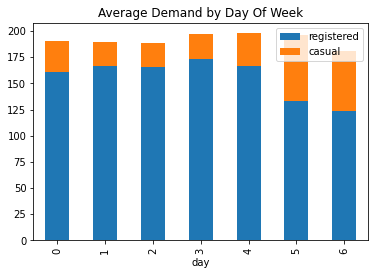

In [23]:
dayofweek_demands = df.groupby('day')[['casual', 'registered', 'count']].mean()
plt.figure(figsize=(12, 12))
dayofweek_demands[['registered', 'casual']].plot(kind='bar', stacked=True)
plt.title('Average Demand by Day Of Week')
plt.show()

In [24]:
dayofweek_demands['casual_prc'] = dayofweek_demands['casual'] / dayofweek_demands['count']
dayofweek_demands

,casual,registered,count,casual_prc
day,,,,
0,29.843972,160.546744,190.390716,0.156751
1,22.979207,166.744639,189.723847,0.121119
2,22.521599,165.889749,188.411348,0.119534
3,24.007083,173.289118,197.296201,0.121680
4,31.001962,166.842381,197.844343,0.156699
5,63.625000,133.040404,196.665404,0.323519
6,57.051298,123.788474,180.839772,0.315480


In [25]:
dayofweek_demands.mean()

casual         35.861446
registered    155.734501
count         191.595947
casual_prc      0.187826
dtype: float64

weekdays:

In [26]:
dayofweek_demands.iloc[0:5].mean()

casual         26.070765
registered    166.662526
count         192.733291
casual_prc      0.135157
dtype: float64

weekends:

In [27]:
dayofweek_demands.iloc[5:].mean()

casual         60.338149
registered    128.414439
count         188.752588
casual_prc      0.319499
dtype: float64

* The average daily demand has similar distribution for all days of week.
* On weekend-days, the casual clients' rate is more than doubled (from 13% to 32% on weekend-days).

Text(0, 0.5, 'Demand (units)')

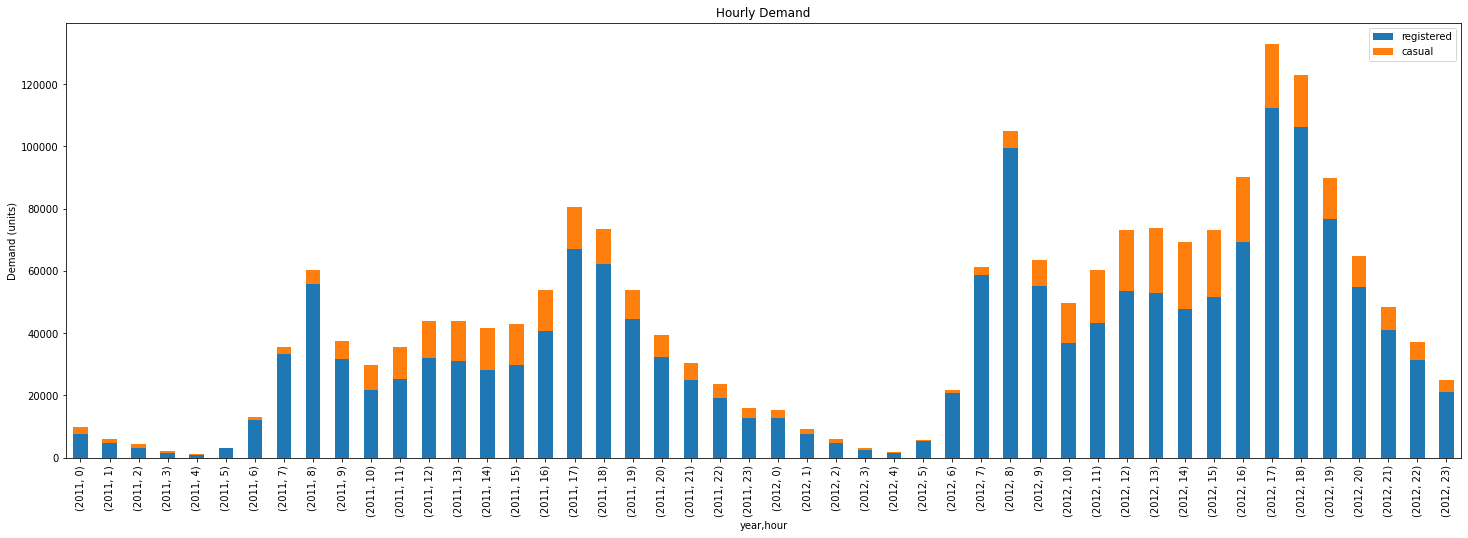

In [28]:
hourly_demands = df.groupby(['year', 'hour'])[['casual', 'registered', 'count']].sum()
hourly_demands[['registered', 'casual']].plot(kind='bar', stacked=True, figsize=(25,8))
plt.title('Hourly Demand')
plt.ylabel('Demand (units)')

In [29]:
def plot_moving_average(series, window, plot_intervals=False, scale=1):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(25,8))
    plt.title(f'Moving average for {series.name}\n window size = {window}')
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='bounds: +- std')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual', alpha=0.5, marker='.')
    plt.legend(loc='best')
    plt.grid(True)

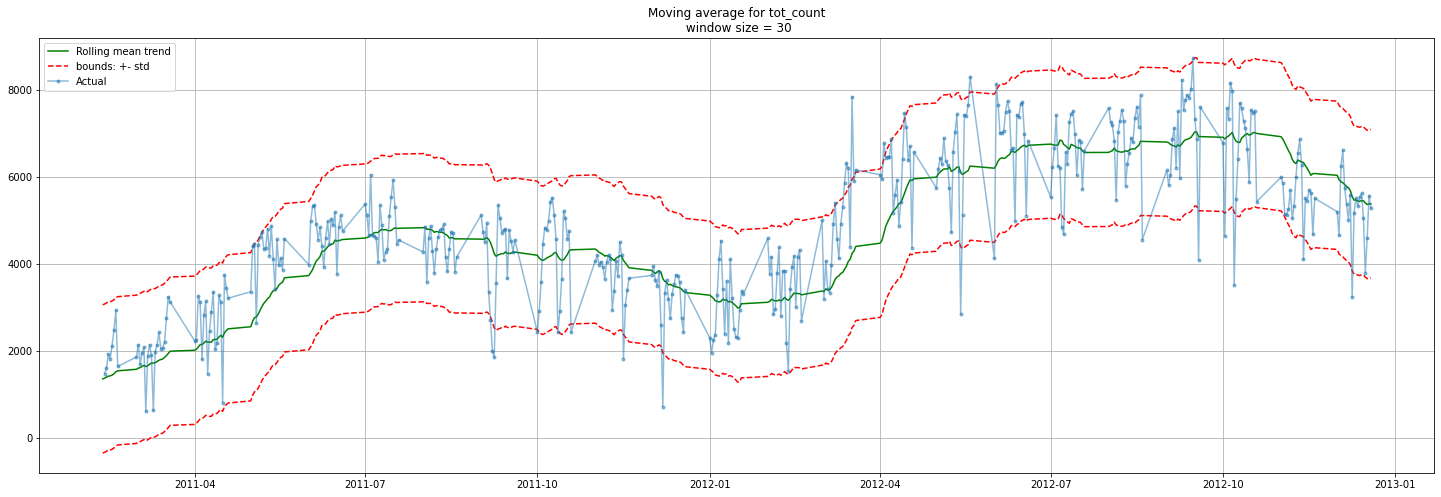

In [30]:
plot_moving_average(daily_df['tot_count'], 30, True)

In [31]:
daily_df['season_desc'] = daily_df['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})

[Text(0, 0.5, 'Daily Demand'),
 Text(0.5, 1.0, 'Box Plot for Daily Demand by Season')]

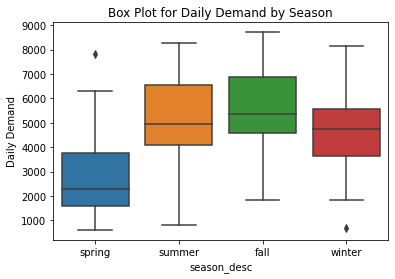

In [32]:
sns.boxplot(data=daily_df,y="tot_count",x="season_desc",orient="v").set(ylabel='Daily Demand',title="Box Plot for Daily Demand by Season")

[Text(0, 0.5, 'Hourly Demand'),
 Text(0.5, 1.0, 'Box Plot for Hourly Demand by weather')]

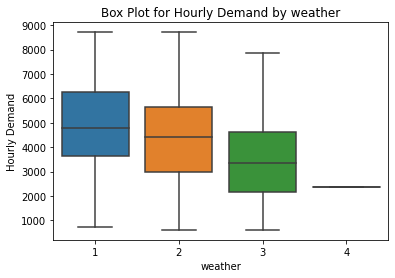

In [33]:
sns.boxplot(data=df,y="tot_count",x="weather",orient="v").set(ylabel='Hourly Demand',title="Box Plot for Hourly Demand by weather")

In [34]:
daily_df.holiday.value_counts() # The number of holiday days is insignificant (2.8%)

0    443
1     13
Name: holiday, dtype: int64

# Roadmap & Assumptions:
1. I choose to analyze the aggregated daily data and optimize the **daily profit** by predicting the best max capacity for each day, since the average daily demand has similar distribution for all days of week (see figure: Box Plot for Daily Demand by Day Of Week).
2. Therefore, I had to drop the weather column although it can be meaningful predictior (see figure: Box Plot for Hourly Demand by weather).
3. To answer the question: What maximum capacity to set for each day? I will try to optimize the daily profit by predicting the best **total** demand for each day.

In [35]:
COST = 10
R_PRICE = 14
C_PRICE = 18
R_REJECTION_COST = 1
C_REJECTION_COST = 0

# Sensativity Analysis

In [36]:
def get_profit(max_capacity, r_demand, c_demand):
    r_prc = r_demand / (r_demand + c_demand)
    operational_cost = max_capacity * COST
    penalty = 0
    
    if r_demand + c_demand > max_capacity:
        income = (max_capacity * r_prc) * R_PRICE + (max_capacity * (1 - r_prc)) * C_PRICE
        penalty = (r_demand - (max_capacity * r_prc)) * R_REJECTION_COST + (c_demand - (max_capacity * (1 - r_prc))) * C_REJECTION_COST
    else:
        income = R_PRICE * r_demand + C_PRICE * c_demand
        
    profit = income - operational_cost - penalty
    return profit
    
                                                                         

Assuming Get Wheels could predict the exact number of the next day demand:

In [37]:
daily_df['max_profit'] = daily_df.apply(lambda x: get_profit(x['tot_count'], x['tot_registered'], x['tot_casual']) , axis=1)

In [38]:
for prc in [.1, .15, .2]:
    daily_df[f'profit_{int(prc*100)}_over'] = daily_df.apply(lambda x: get_profit(x['tot_count']*(1+prc), x['tot_registered'], x['tot_casual']) , axis=1)
    daily_df[f'profit_{int(prc*100)}_under'] = daily_df.apply(lambda x: get_profit(x['tot_count']*(1-prc), x['tot_registered'], x['tot_casual']) , axis=1)
profits_df = pd.DataFrame(daily_df[['profit_20_over','profit_15_over', 'profit_10_over', 'max_profit', 'profit_10_under', 'profit_15_under', 'profit_20_under']].sum(), columns=['profit'])

In [39]:
profits_df['max_profit_ratio'] = profits_df['profit'] / profits_df.loc['max_profit'].values[0] 
t = profits_df.loc[['profit_10_over', 'max_profit', 'profit_10_under']]
t['marginal_profit'] = t.apply(lambda x: (x['max_profit_ratio']-1)/10, axis=1)
t

,profit,max_profit_ratio,marginal_profit
profit_10_over,7824968.0,0.789568,-0.021043
max_profit,9910444.0,1.000000,0.000000
profit_10_under,8750065.5,0.882914,-0.011709


* The additional revenue that will be generate by increasing the maximum capacity by 1% over the total demand is -2.1%
* The additional revenue that will be generate by decreasing the maximum capacity by 1% under the total demand is -1.2%

Text(0, 0.5, 'Total Profit')

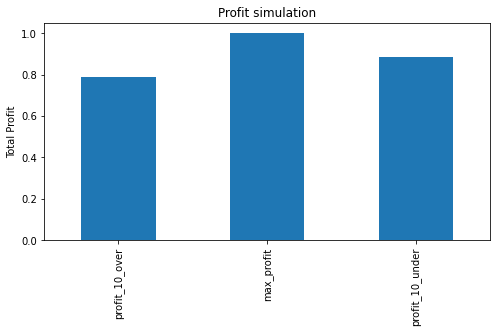

In [40]:
t['max_profit_ratio'].plot(kind='bar', figsize=(8, 4))
plt.title('Profit simulation')
plt.ylabel('Total Profit')

# Prediction Models

> I used nested cross validation for time series

> The best parameter for each fold selected using grid search



1.   Naive Model - set the max capacity as the average daily demand in the previous week.
2.   KNeighborsRegressor
3.   RandomForestRegressor
4.   XGBRegressor




Results:


1.   The naive model has the best mean average error: 756 (daily average)
2.   Profit ratio: 

>
*   naive - 77%
*   XGBoost - 76%
*   RF - 74%
*   KNN - 55%


> 
> 
> 
> 



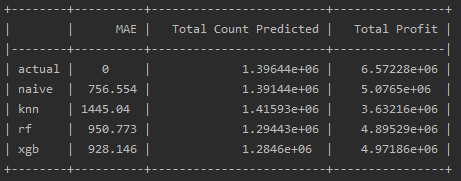

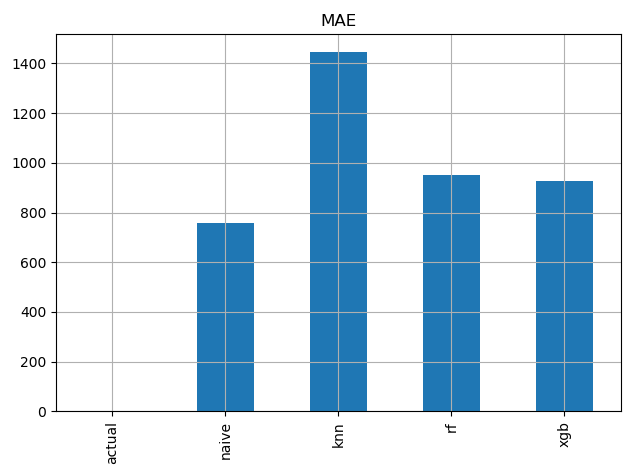

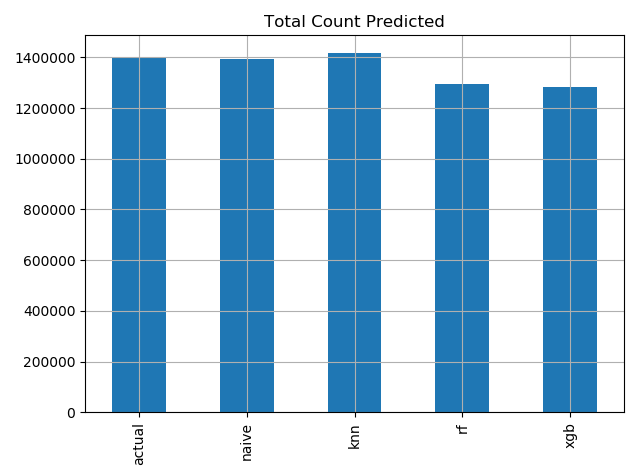

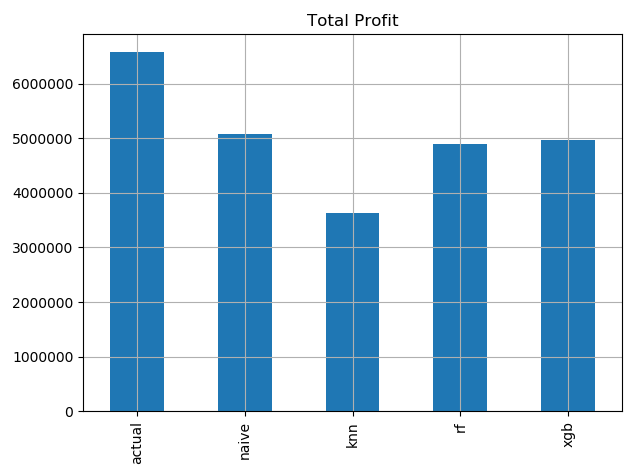

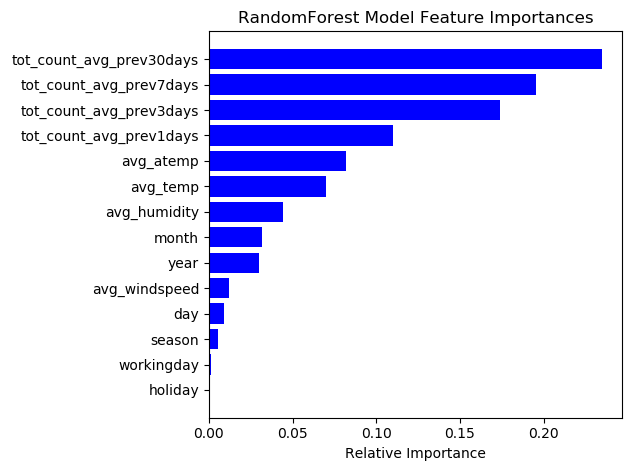

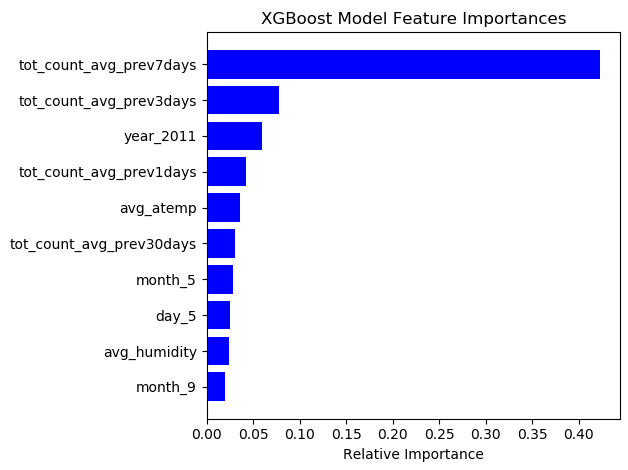

# Future Work:

* Predict the registered and casual clients' demand separately.
* Use the row data (demands per hour) and compare its results to the daily aggregated data.